**Interpretable AI System for Uncertainty-Aware Delivery Delay Prediction in Fleet Logistics Using SHAP and Probabilistic Modeling**

**Goal**

To build an interpretable machine learning model that predicts delivery delays and quantifies uncertainty, supporting proactive decision-making in fleet management.

**Intended Audience**


1. AI/ML Research Analysts

2. Fleet and Logistics Managers

3. Data Scientists in Transportation

4. Business Intelligence Teams

**Strategy & Pipeline Steps**

**Step 1: Mount Google Drive and Load Dataset**

In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Fleet & Logistics/Delivery truck trip data.xlsx'
df = pd.read_excel(file_path)
df.head()


Mounted at /content/drive


,GpsProvider,BookingID,Market/Regular,BookingID_Date,vehicle_no,Origin_Location,Destination_Location,Org_lat_lon,Des_lat_lon,Data_Ping_time,...,TRANSPORTATION_DISTANCE_IN_KM,vehicleType,Minimum_kms_to_be_covered_in_a_day,Driver_Name,Driver_MobileNo,customerID,customerNameCode,supplierID,supplierNameCode,Material Shipped
0,CONSENT TRACK,MVCV0000927/082021,Market,2020-08-17 14:59:01.000,KA590408,"TVSLSL-PUZHAL-HUB,CHENNAI,TAMIL NADU","ASHOK LEYLAND PLANT 1- HOSUR,HOSUR,KARNATAKA","13.1550,80.1960","12.7400,77.8200",2020-08-24 00:05:09,...,320.0,NaN,NaN,NaN,NaN,ALLEXCHE45,Ashok leyland limited,VIJEXHOSR7,VIJAY TRANSPORT,BRACKET / GRAB HANDLE
1,VAMOSYS,VCV00014271/082021,Regular,2020-08-27 16:22:22.827,TN30BC5917,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:28,...,103.0,NaN,NaN,RAMESH,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,VJLEXSHE09,VJ LOGISTICS,ZB MODEL PLATE / 3143
2,CONSENT TRACK,VCV00014382/082021,Regular,2020-08-27 17:59:24.987,TN22AR2748,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8710,79.7390","11.8710,79.7390",2020-08-28 09:05:09,...,300.0,NaN,NaN,GIRI,NaN,LUTGCCHE06,Lucas tvs ltd,GSTEXLAK1Q,G.S. TRANSPORT,LETTERING / FUSO
3,VAMOSYS,VCV00014743/082021,Regular,2020-08-28 00:48:24.503,TN28AQ0781,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:31,...,61.0,NaN,NaN,RAVI,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,ARVEXNAM09,ARVINTH TRANSPORT,LU STRUT RA / RADIUS ROD
4,VAMOSYS,VCV00014744/082021,Regular,2020-08-28 01:23:19.243,TN68F1722,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8720,79.6320","11.8720,79.6320",2020-08-28 12:40:29,...,240.0,NaN,NaN,TAMIL,NaN,LUTGCCHE06,Lucas tvs ltd,SRTEXKOR96,SR TRANSPORTS,WISHBONE / V ROD/HDT


** Step 2: Data Cleaning & Feature Creation**

In [4]:
# Convert dates
df['Planned_ETA'] = pd.to_datetime(df['Planned_ETA'])
df['actual_eta'] = pd.to_datetime(df['actual_eta'])

# Delay in minutes
df['delay_minutes'] = (df['actual_eta'] - df['Planned_ETA']).dt.total_seconds() / 60

# Label as delayed if delay > 15 minutes
df['is_delayed'] = df['delay_minutes'] > 15


**3. Model Dataset Preparation**

In [5]:
# Features for prediction
X = df[['TRANSPORTATION_DISTANCE_IN_KM', 'Minimum_kms_to_be_covered_in_a_day']]
y = df['is_delayed']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**4. Train a Logistic Regression Model**

In [7]:
# Drop duplicates and fill missing values
df.drop_duplicates(inplace=True)
df.fillna(method='ffill', inplace=True)

# Convert dates
df['Planned_ETA'] = pd.to_datetime(df['Planned_ETA'])
df['actual_eta'] = pd.to_datetime(df['actual_eta'])

# Delay in minutes
df['delay_minutes'] = (df['actual_eta'] - df['Planned_ETA']).dt.total_seconds() / 60

# Label as delayed if delay > 15 minutes
df['is_delayed'] = df['delay_minutes'] > 15

# Features for prediction
X = df[['TRANSPORTATION_DISTANCE_IN_KM', 'Minimum_kms_to_be_covered_in_a_day']]
y = df['is_delayed']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Create an imputer to fill NaN values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train = imputer.fit_transform(X_train) # Fit and transform on X_train
X_test = imputer.transform(X_test) # Transform X_test

model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

<ipython-input-7-ef0e975a4b6e>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


**5. Visualize Prediction Uncertainty**

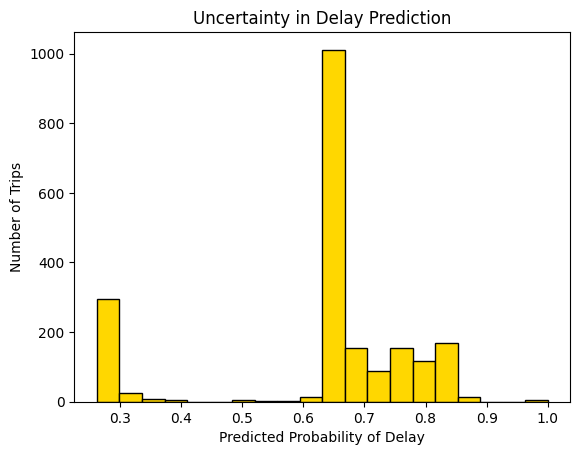

In [8]:
import matplotlib.pyplot as plt

plt.hist(y_probs, bins=20, color='gold', edgecolor='black')
plt.title("Uncertainty in Delay Prediction")
plt.xlabel("Predicted Probability of Delay")
plt.ylabel("Number of Trips")
plt.show()


** Interpretation of the Histogram**

The chart shows the distribution of predicted delay probabilities for delivery trips. Most predictions cluster sharply around 0.65, indicating the model often predicts a moderate chance of delay. This peak reflects high uncertainty, as it suggests the model isn't confident whether those trips will be delayed or not.

A smaller number of trips are confidently predicted (e.g., near 0.25 or 0.85), where the model is more certain about delay likelihood.

**⚙️ Operational Significance**

This insight helps fleet managers:

- Flag borderline trips for closer review or buffer time.

- Prioritize dispatching resources for trips with high uncertainty.

- Improve trust in AI predictions by showing where the model is uncertain.

**6. Interpret with SHAP for Transparency**

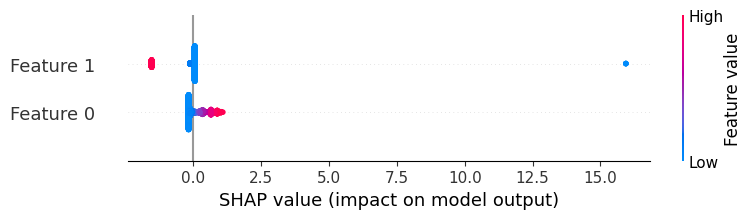

In [9]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


**SHAP Summary Overview**

The SHAP plot shows how two features impact delivery delay predictions. The x-axis represents the SHAP value (impact on model output), while the color indicates feature value (blue = low, red = high).

🚚 **Feature 0: Transportation Distance**

This feature has a modest effect. High distances slightly increase delay risk, but most values cluster near zero, suggesting distance alone isn't a strong delay driver. However, longer trips still warrant buffer planning.

**📉 Feature 1: Minimum KM per Day**

This has a stronger influence. Lower daily distance targets (blue dots) lead to significantly higher delay predictions. It suggests underutilized routes or inefficiencies that may result in missed deadlines. Optimizing daily targets could improve reliability.

⚙️** Operational Insight**

SHAP reveals that low performance expectations are more predictive of delays than long trips. This guides smarter scheduling, target setting, and transparency in fleet AI systems.

**Challenges**

- Highly imbalanced predictions near 0.65 indicate model uncertainty.

- Limited feature diversity affects performance generalization.

- Predicting delays accurately requires integrating external signals (weather, traffic, driver behavior).

**Problem Statement**

Fleet managers lack an explainable system to anticipate delivery delays and assess confidence in AI decisions. This project aims to fill that gap using delay prediction with uncertainty modeling and SHAP-based transparency.

**Dataset**

Delivery Truck Trip Data
Fields include:

- Origin, Destination, Distance

- Planned vs Actual ETA

- Vehicle and Driver Info

- Delay Flag, Performance Benchmarks



**Machine Learning Prediction & Outcomes**

**Histogram Interpretation**


The delay probability distribution is skewed toward 0.65, showing high model uncertainty for many trips. Fewer trips fall near 0.25 or 0.85, where predictions are more confident. This suggests borderline cases are common and require close attention.


**SHAP Summary Interpretation**


- Transportation Distance (Feature 0): Slight positive impact on delay. Long routes raise delay risk slightly.


- Minimum KM/Day (Feature 1): Stronger predictor. Low targets significantly increase delay probability.


- Insight: Underutilized routes are more delay-prone than long routes, guiding better KPI calibration and scheduling.

**Trailer Documentation**

This project showcases the value of uncertainty-aware modeling for real-world logistics. It supports smarter route decisions, resource allocation, and operational accountability using interpretable AI.



**Conceptual Enhancement – AGI (Artificial General Intelligence)**

In future iterations, this system could integrate external dynamic data (weather, IoT sensor feeds, road closures), moving closer to AGI-like reasoning in logistics by enabling adaptive, self-improving delivery routing systems.

**Academic & Technical References**

1. SHAP (SHapley Additive exPlanations)
Lundberg, S. M., & Lee, S. I. (2017). A Unified Approach to Interpreting Model Predictions.
➤ https://arxiv.org/abs/1705.07874

2. Uncertainty in Machine Learning
Abdar, M., et al. (2021). A review of uncertainty quantification in deep learning: Techniques, applications and challenges.
Information Fusion, Volume 76, 2021, pp. 243–297.
➤ https://doi.org/10.1016/j.inffus.2021.05.008

3. Logistic Regression for Classification
Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). Applied Logistic Regression (3rd ed.). Wiley.

4. AI in Logistics Optimization
Accenture & DHL. (2018). Artificial Intelligence in Logistics: A collaborative report by DHL and IBM on implications and use cases for the logistics industry.
➤ https://www.logistics.dhl/content/dam/dhl/global/core/documents/pdf/glo-core-ai-in-logistics.pdf

